In [39]:
!pip install opencv-python-headless scikit-image matplotlib

In [40]:
# import lib
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
from skimage.measure import label, regionprops
from skimage.color import label2rgb

# Preprocessing

In [41]:
# Load imgs
img1 = cv2.imread('/content/img_1.png')
img2 = cv2.imread('/content/img_2.png')

# Convert BGR to RGB
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

In [42]:
# Histogram matching / (env correction)
def match_histogram(source, reference):
    matched = np.empty_like(source)
    for c in range(3):  # match channels
        matched[..., c] = exposure.match_histograms(source[..., c], reference[..., c])
    return matched

img2_matched = match_histogram(img2_rgb, img1_rgb)

In [43]:
# Feature based alignment
def align_images(base_img, to_align_img):
    gray1 = cv2.cvtColor(base_img, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(to_align_img, cv2.COLOR_RGB2GRAY)

    orb = cv2.ORB_create(5000)
    kp1, des1 = orb.detectAndCompute(gray1, None)
    kp2, des2 = orb.detectAndCompute(gray2, None)

    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = matcher.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)[:500]

    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

    H, _ = cv2.findHomography(pts2, pts1, cv2.RANSAC)
    aligned_img = cv2.warpPerspective(to_align_img, H, (base_img.shape[1], base_img.shape[0]))

    return aligned_img

aligned_img2 = align_images(img1_rgb, img2_matched)

In [44]:
# Detect Changes
diff = cv2.absdiff(img1_rgb, aligned_img2)
gray_diff = cv2.cvtColor(diff, cv2.COLOR_RGB2GRAY)
_, binary_diff = cv2.threshold(gray_diff, 30, 255, cv2.THRESH_BINARY)

# Morphological cleanup
kernel = np.ones((5,5),np.uint8)
cleaned = cv2.morphologyEx(binary_diff, cv2.MORPH_OPEN, kernel)
cleaned = cv2.dilate(cleaned, kernel, iterations=1)

# Segmentation
labeled = label(cleaned)

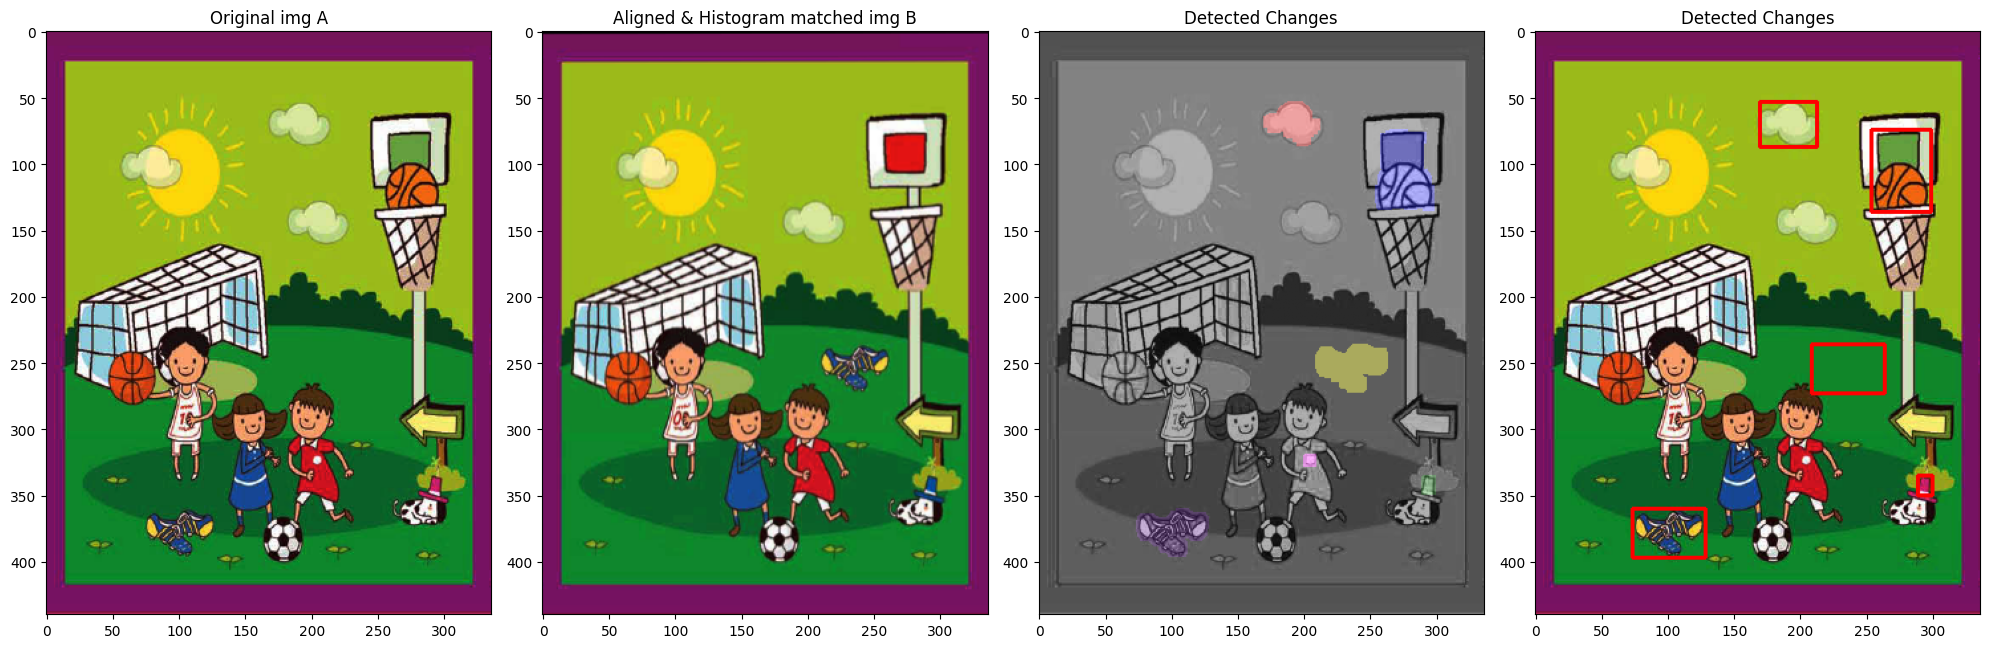

In [48]:

image_label_overlay = label2rgb(labeled, image=img1_rgb, bg_label=0)
min_area = 100  # threshold
boxed_img = img1_rgb.copy()

for region in regionprops(labeled):
    if region.area >= min_area:
        minr, minc, maxr, maxc = region.bbox
        cv2.rectangle(boxed_img, (minc, minr), (maxc, maxr), (255, 0, 0), 2)  # Red box (BGR)

# Display results
plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.title("Original img A")
plt.imshow(img1_rgb)

plt.subplot(1, 4, 2)
plt.title("Aligned & Histogram matched img B")
plt.imshow(aligned_img2)

plt.subplot(1, 4, 3)
plt.title("Detected Changes")
plt.imshow(image_label_overlay)

plt.subplot(1, 4, 4)
plt.title("Detected Changes")
plt.imshow(boxed_img)

plt.tight_layout()
plt.show()